In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange


import flygym.common
import flygym.mujoco
import flygym.mujoco.preprogrammed

from flygym.mujoco import Parameters


from nmf_grooming import (
    NeuromechflyGrooming,
    all_groom_dofs,
    load_grooming_data,
    plot_state_and_contacts,
)
from scipy.signal import find_peaks, medfilt
from IPython.display import Video

from flygym.mujoco.examples.rule_based_controller import PreprogrammedSteps

In [91]:
class NeuromechflyDust(NeuromechflyGrooming):
    def __init__(
        self,
        back,
        sim_params,
        init_dust_level=5.0,
        saturation_level=10.0,
        ant_decay=0.05,
        abdomen_decay=0.01,
        eye_decay=0.01,
        foreleg_decay=0.01,
        hindleg_decay=0.01,
        dusted_areas = [],
        touch_thr=1.0,
    ):
        self.back = back
        print("back", back)
        if self.back == 0:
            self.dusted_areas = ["R_antenna", "L_antenna", "RF_leg", "LF_leg", "R_eye", "L_eye"]
            
            print("back", back)
            self.bodies_in_app = {
                "R_antenna": ["RPedicel", "RArista", "RFuniculus"],
                "L_antenna": ["LPedicel", "LArista", "LFuniculus"],
                "RF_leg": [
                    "RFTarsus1",
                    "RFTarsus2",
                    "RFTarsus3",
                    "RFTarsus4",
                    "RFTarsus5",
                    "RFTibia",
                ],
                "LF_leg": [
                    "LFTarsus1",
                    "LFTarsus2",
                    "LFTarsus3",
                    "LFTarsus4",
                    "LFTarsus5",
                    "LFTibia",
                ],
                "R_eye": ["REye"],
                "L_eye": ["LEye"],
            }
        else:
            self.dusted_areas = ["RH_leg", "LH_leg", "Abdomen"]
            self.bodies_in_app = {
                "RH_leg": [
                    "RHTarsus1",
                    "RHTarsus2",
                    "RHTarsus3",
                    "RHTarsus4",
                    "RHTarsus5",
                    "RHTibia",
                ],
                "LH_leg": [
                    "LHTarsus1",
                    "LHTarsus2",
                    "LHTarsus3",
                    "LHTarsus4",
                    "LHTarsus5",
                    "LHTibia",
                ],
                "Abdomen": [
                    "A1A2",
                    "A3",
                    "A4",
                    "A5",
                    #"A6",
                            ],
            }

        self.dusted_bodies = [
            body for area in self.dusted_areas for body in self.bodies_in_app[area]
        ]
        print("dusted_bodies", self.dusted_bodies)
        # check if the dust level is a list
        self.saturation_level = saturation_level
        if isinstance(init_dust_level, list):
            self.dust_level = np.array(init_dust_level)
        else:
            self.dust_level = np.ones(len(self.dusted_areas)) * init_dust_level
        self.dust_level = np.clip(self.dust_level, 0.0, self.saturation_level)

        self.touch_thr = touch_thr
        if self.back == 0:
            self.ant_dust_decay = ant_decay
            self.eye_dust_decay = eye_decay
            self.foreleg_dust_decay = foreleg_decay
        else:
            self.hindleg_dust_decay = hindleg_decay
            self.abdomen_dust_decay = abdomen_decay

        touch_sensors_locations = []
        self.touch_sensors_ids = []
        self.appendage_touch_sensors = [[]] * len(self.dusted_areas)
        for i, area in enumerate(self.dusted_areas):
            n_touch_sensors_previous = len(touch_sensors_locations)
            if area in self.bodies_in_app:
                touch_sensors_locations += self.bodies_in_app[area]
            else:
                raise ValueError("Unknown dusted area")
            self.appendage_touch_sensors[i] = np.arange(
                n_touch_sensors_previous, len(touch_sensors_locations)
            )

        self.baseline_rgba = np.array([1.0, 1.0, 1.0, 1.0])
        self.no_dust_color = np.array([0.59, 0.39, 0.12, 1.0])
        self.full_dust_color = np.array([0.0, 1.0, 0.0, 1.0])

        super().__init__(
            sim_params=sim_params,
            groom_collision=True,
            touch_sensor_locations=touch_sensors_locations,
        )

        self.update_segment_aspect()

    def _set_geom_colors(self):
        if self.back == 0:
            self.areas_materials = {}
            self.areas_materials["RF_leg"] = []
            self.areas_materials["LF_leg"] = []
            for type_, specs in self._mujoco_config["appearance"].items():
                
            # If part of the dusted bodies, set the color to the baseline
                dusted_bodies_type_match = [
                    db[2:-1].lower() in type_ for db in self.dusted_bodies
                ]
                if (
                    "antenna" in type_
                    or any(dusted_bodies_type_match)
                    and not "arista" in type_
                ):
                    specs["material"]["rgba"] = self.baseline_rgba
                    if type_ == "eye":
                        specs["texture"] = self._mujoco_config["appearance"]["antenna"][
                            "texture"
                        ]
                        specs["texture"]["rgb1"] = self.baseline_rgba[:3]
                        specs["texture"]["rgb2"] = self.baseline_rgba[:3]
                        specs["texture"]["width"] = 1e6
                        specs["texture"]["height"] = 1e6
                        specs["texture"]["random"] = 1e-5
                    elif specs["texture"] is not None:
                        specs["texture"]["rgb1"] = self.baseline_rgba[:3]
                        specs["texture"]["rgb2"] = self.baseline_rgba[:3]

        else:
        
            self.areas_materials = {}
            self.areas_materials["RH_leg"] = []
            self.areas_materials["LH_leg"] = []

            for type_, specs in self._mujoco_config["appearance"].items():
                # If part of the dusted bodies, set the color to the baseline
                dusted_bodies_type_match = [
                    db[2:-1].lower() in type_ for db in self.dusted_bodies
                ]
                if (
                    "a12345" in type_
                    or any(dusted_bodies_type_match)
                ):
                    specs["material"]["rgba"] = self.baseline_rgba
                    if type_ == "a6":
                        specs["texture"] = self._mujoco_config["appearance"]["a12345"][
                            "texture"
                        ]
                        specs["texture"]["rgb1"] = self.baseline_rgba[:3]
                        specs["texture"]["rgb2"] = self.baseline_rgba[:3]
                        specs["texture"]["width"] = 1e6
                        specs["texture"]["height"] = 1e6
                        specs["texture"]["random"] = 1e-5
                    elif specs["texture"] is not None:
                        specs["texture"]["rgb1"] = self.baseline_rgba[:3]
                        specs["texture"]["rgb2"] = self.baseline_rgba[:3]

        

            # Define texture and material
            if specs["texture"] is not None:
                self.model.asset.add(
                    "texture",
                    name=f"{type_}_texture",
                    builtin=specs["texture"]["builtin"],
                    mark="random",
                    width=specs["texture"]["size"],
                    height=specs["texture"]["size"],
                    random=specs["texture"]["random"],
                    rgb1=specs["texture"]["rgb1"],
                    rgb2=specs["texture"]["rgb2"],
                    markrgb=specs["texture"]["markrgb"],
                )
            self.model.asset.add(
                "material",
                name=f"{type_}_material",
                texture=f"{type_}_texture" if specs["texture"] is not None else None,
                rgba=specs["material"]["rgba"],
                specular=0.0,
                shininess=0.0,
                reflectance=0.0,
                texuniform=True,
            )
            # Apply to geoms
            for segment in specs["apply_to"]:
                geom = self.model.find("geom", segment)
                if geom is None:
                    geom = self.model.find("geom", f"{segment}")
                geom.material = f"{type_}_material"

    def get_observation(self):
        obs = super().get_observation()

        appendage_touch = [
            np.sum(obs["touch_sensors"][touch_sensors])
            for touch_sensors in self.appendage_touch_sensors
        ]

        if self.back == 0:
            R_antenna_contact = np.mean(
                appendage_touch[self.dusted_areas.index("R_antenna")]
            )
            L_antenna_contact = np.mean(
                appendage_touch[self.dusted_areas.index("L_antenna")]
            )
            RF_leg_contact = np.mean(appendage_touch[self.dusted_areas.index("RF_leg")])
            LF_leg_contact = np.mean(appendage_touch[self.dusted_areas.index("LF_leg")])
            R_eye_contact = np.mean(appendage_touch[self.dusted_areas.index("R_eye")])
            L_eye_contact = np.mean(appendage_touch[self.dusted_areas.index("L_eye")])
            Abdomen_contact = 0.0
            RH_leg_contact = 0.0
            LH_leg_contact = 0.0
        
        else:
            R_antenna_contact = 0.0
            L_antenna_contact = 0.0
            RF_leg_contact = 0.0
            LF_leg_contact = 0.0
            R_eye_contact = 0.0
            L_eye_contact = 0.0
            Abdomen_contact = np.mean(
                appendage_touch[self.dusted_areas.index("Abdomen")]
            )
            RH_leg_contact = np.mean(appendage_touch[self.dusted_areas.index("RH_leg")])
            LH_leg_contact = np.mean(appendage_touch[self.dusted_areas.index("LH_leg")])

        if self.back == 0:
            is_Rantenna_grooming = (
                R_antenna_contact > self.touch_thr
                and RF_leg_contact > self.touch_thr
                and LF_leg_contact > self.touch_thr
                and not self.back
            )

            is_Lantenna_grooming = (
                L_antenna_contact > self.touch_thr
                and RF_leg_contact > self.touch_thr
                and LF_leg_contact > self.touch_thr
                and not self.back
            )
            
            is_eye_grooming = (
                R_eye_contact > self.touch_thr
                and RF_leg_contact > self.touch_thr
                and L_eye_contact > self.touch_thr
                and LF_leg_contact > self.touch_thr
                and not self.back
            )

            is_foreleg_grooming = (
                RF_leg_contact > self.touch_thr
                and LF_leg_contact > self.touch_thr
                and not is_Rantenna_grooming
                and not is_Lantenna_grooming
                and not is_eye_grooming
                and not self.back
            )

            is_Abdomen_grooming = self.back

            is_hindleg_grooming = self.back

        else:
            is_Rantenna_grooming = not self.back
            is_Lantenna_grooming = not self.back
            is_eye_grooming = not self.back
            is_foreleg_grooming = not self.back

            is_Abdomen_grooming = (
                Abdomen_contact > self.touch_thr
                and RH_leg_contact > self.touch_thr
                and LH_leg_contact > self.touch_thr
                and self.back
            )

            is_hindleg_grooming = (
                RH_leg_contact > self.touch_thr
                and LH_leg_contact > self.touch_thr
                and not is_Abdomen_grooming
                and self.back
            )

        self.update_dust_level(
            is_foreleg_grooming,
            is_Rantenna_grooming,
            is_Lantenna_grooming,
            is_eye_grooming,
            R_antenna_contact,
            L_antenna_contact,
            RF_leg_contact,
            LF_leg_contact,
            R_eye_contact,
            L_eye_contact,
            is_Abdomen_grooming,
            is_hindleg_grooming,
            Abdomen_contact,
            RH_leg_contact,
            LH_leg_contact,
        )

        self.update_segment_aspect()

        # add curr behavior
        obs["is_foreleg_grooming"] = is_foreleg_grooming
        obs["is_Rantenna_grooming"] = is_Rantenna_grooming
        obs["is_Lantenna_grooming"] = is_Lantenna_grooming
        obs["is_eye_grooming"] = is_eye_grooming
        obs["is_hindleg_grooming"] = is_hindleg_grooming
        obs["is_Abdomen_grooming"] = is_Abdomen_grooming

        assert all(self.dust_level >= 0.0) and all(
            self.dust_level <= self.saturation_level
        ), f"Dust level out of bounds: {self.dust_level}"
        # add dust level
        obs["dust_level"] = self.dust_level

        return obs

    def update_segment_aspect(self):
        # change body rgba depending on dust level
        for app, dl in zip(self.dusted_areas, self.dust_level):
            for body in self.bodies_in_app[app]:
                if not "Arista" in body:
                    norm_dl = (dl.copy() - 0.0) / (self.saturation_level - 0.0)
                    self.physics.named.model.geom_rgba[
                        f"Animat/{body}"
                    ] = self.interp_color(norm_dl)

    def interp_color(self, dust_level):
        return (
            self.no_dust_color
            + (self.full_dust_color - self.no_dust_color) * dust_level
        )

    def update_dust_level(
        self,
        is_foreleg_grooming,
        is_Rantenna_grooming,
        is_Lantenna_grooming,
        is_eye_grooming,
        R_antenna_contact,
        L_antenna_contact,
        RF_leg_contact,
        LF_leg_contact,
        R_eye_contact,
        L_eye_contact,
        is_Abdomen_grooming,
        is_hindleg_grooming,
        Abdomen_contact,
        RH_leg_contact,
        LH_leg_contact,
    ):
        is_saturated = self.dust_level >= self.saturation_level
        saturated_app = [
            self.dusted_areas[i] for i, sat in enumerate(is_saturated) if sat
        ]
        is_zero = self.dust_level <= 0.0
        zero_app = [self.dusted_areas[i] for i, zero in enumerate(is_zero) if zero]
    
        if self.back == 0:

            # update dust level bodies that have no dust should not give dust to the forelegs,
            # when the forelegs are saturated, they can not pick up dust anymore
            if is_Rantenna_grooming and not "R_antenna" in zero_app:
                removed_dust = (
                    np.mean([R_antenna_contact, RF_leg_contact, LF_leg_contact])
                    * self.ant_dust_decay
                )
                removed_dust = self.update_leg_dust_antgroom(
                    saturated_app, removed_dust
                )
                self.dust_level[self.dusted_areas.index("R_antenna")] -= removed_dust
            if is_Lantenna_grooming and not "L_antenna" in zero_app:
                removed_dust = (
                    np.mean([L_antenna_contact, RF_leg_contact, LF_leg_contact])
                    * self.ant_dust_decay
                )
                removed_dust = self.update_leg_dust_antgroom(
                    saturated_app, removed_dust
                )
                self.dust_level[self.dusted_areas.index("L_antenna")] -= removed_dust
            if is_eye_grooming and (not "R_eye" in zero_app or not "L_eye" in zero_app):
                removed_dust = (
                    np.mean([R_eye_contact, L_eye_contact, RF_leg_contact, LF_leg_contact])
                    * self.eye_dust_decay
                )
                if "R_eye" in zero_app:
                    # if added to saturated_app no dust can be added to it
                    saturated_app.append("RF_leg")
                elif "L_eye" in zero_app:
                    saturated_app.append("LF_leg")
                removed_dust = self.update_leg_dust_antgroom(
                    saturated_app, removed_dust
                )
                if not "R_eye" in zero_app:
                    self.dust_level[self.dusted_areas.index("R_eye")] -= removed_dust
                if not "L_eye" in zero_app:
                    self.dust_level[self.dusted_areas.index("L_eye")] -= removed_dust
            if is_foreleg_grooming and (not "RF_leg" in zero_app or not "LF_leg" in zero_app):
                removed_dust = (
                    np.mean([RF_leg_contact, LF_leg_contact]) * self.foreleg_dust_decay
                )
                if "RF_leg" in zero_app and "LF_leg" in zero_app:
                    removed_dust = 0
                elif "RF_leg" in zero_app:
                    self.dust_level[self.dusted_areas.index("LF_leg")] -= removed_dust / 2
                elif "LF_leg" in zero_app:
                    self.dust_level[self.dusted_areas.index("RF_leg")] -= removed_dust / 2
                else:
                    self.dust_level[self.dusted_areas.index("RF_leg")] -= removed_dust / 2
                    self.dust_level[self.dusted_areas.index("LF_leg")] -= removed_dust / 2

        else:
            
            # update dust level bodies that have no dust should not give dust to the forelegs,
            # when the forelegs are saturated, they can not pick up dust anymore
            if is_Abdomen_grooming and not "Abdomen" in zero_app:
                removed_dust = (
                    np.mean([Abdomen_contact, RH_leg_contact, LH_leg_contact])
                    * self.abdomen_dust_decay
                )
                removed_dust = self.update_leg_dust_antgroom(
                    saturated_app, removed_dust
                )
                self.dust_level[self.dusted_areas.index("Abdomen")] -= removed_dust
            
            if is_hindleg_grooming and (not "RH_leg" in zero_app or not "LH_leg" in zero_app):
                removed_dust = (
                    np.mean([RH_leg_contact, LH_leg_contact]) * self.hindleg_dust_decay
                )
                if "RH_leg" in zero_app and "LH_leg" in zero_app:
                    removed_dust = 0
                elif "RH_leg" in zero_app:
                    self.dust_level[self.dusted_areas.index("LH_leg")] -= removed_dust / 2
                elif "LH_leg" in zero_app:
                    self.dust_level[self.dusted_areas.index("RH_leg")] -= removed_dust / 2
                else:
                    self.dust_level[self.dusted_areas.index("RH_leg")] -= removed_dust / 2
                    self.dust_level[self.dusted_areas.index("LH_leg")] -= removed_dust / 2

        self.dust_level = np.clip(self.dust_level, 0.0, self.saturation_level)

    def update_leg_dust_antgroom(self, saturated_app, supposed_removed_dust):
        if self.back == 0:
            if "LF_leg" in saturated_app and "RF_leg" in saturated_app:
                return 0.0
            elif "RF_leg" in saturated_app:
                self.dust_level[self.dusted_areas.index("RF_leg")] += (
                    supposed_removed_dust / 2
                )
                return supposed_removed_dust / 2
            elif "LF_leg" in saturated_app:
                self.dust_level[self.dusted_areas.index("LF_leg")] += (
                    supposed_removed_dust / 2
                )
                return supposed_removed_dust / 2
            else:
                self.dust_level[self.dusted_areas.index("RF_leg")] += (
                    supposed_removed_dust / 2
                )
                self.dust_level[self.dusted_areas.index("LF_leg")] += (
                    supposed_removed_dust / 2
                )
                return supposed_removed_dust / 2
        else:
            if "LH_leg" in saturated_app and "RH_leg" in saturated_app:
                return 0.0
            elif "RH_leg" in saturated_app:
                self.dust_level[self.dusted_areas.index("RH_leg")] += (
                    supposed_removed_dust / 2
                )
                return supposed_removed_dust / 2
            elif "LH_leg" in saturated_app:
                self.dust_level[self.dusted_areas.index("LH_leg")] += (
                    supposed_removed_dust / 2
                )
                return supposed_removed_dust / 2
            else:
                self.dust_level[self.dusted_areas.index("RH_leg")] += (
                    supposed_removed_dust / 2
                )
                self.dust_level[self.dusted_areas.index("LH_leg")] += (
                    supposed_removed_dust / 2
                )
                return supposed_removed_dust / 2
            

In [92]:
grooming_module_path = Path("./data/grooming_modules_provided_slow.pkl")
with open(grooming_module_path, "rb") as f:
    grooming_modules = pickle.load(f)

timestep = grooming_modules["timestep"]

In [100]:
sim_params = Parameters(
    timestep=timestep,
    render_mode="saved",
    render_playspeed=0.1,
    actuator_kp=10.0,
    render_camera="Animat/camera_front",
)

run_time = 1.0
target_num_steps = int(run_time / timestep)

nmf = NeuromechflyDust(
    sim_params=sim_params,
    back = 0,
    init_dust_level=5.0,
    ant_decay=0.01,
    eye_decay=0.015,
    foreleg_decay=0.005,
)

np.random.seed(0)

obs_list = []
obs, info = nmf.reset()
obs_list.append(obs)

module_len = {
    module: len(grooming_modules[module][0])
    for module in grooming_modules
    if module != "timestep"
}

transition_period = 200
transit_to = ["L_antenna", "foreleg", "eyes", "L_antenna"]
transit_times = [0, 1000, 3400, 4500]

k = 0

get_transition_joint_angles = lambda before, after, k: before + (after - before) * min(
    1, (k / transition_period)
)

modules = []

for i in trange(target_num_steps):
    if i in transit_times:
        k = 1
        curr_module = transit_to[transit_times.index(i)]
        print(f"Transit to {curr_module}")
        before_transition_pose = obs["joints"][0]
    else:
        k += 1

    target_joint_angles = grooming_modules[curr_module][:, k % module_len[curr_module]]
    joint_pos = get_transition_joint_angles(
        before_transition_pose, target_joint_angles, k
    )

    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)

    obs_list.append(obs)
    modules.append(curr_module)

    nmf.render()

modules.append(curr_module)
nmf.save_video("outputs/dust_grooming_sequence.mp4", 0)

back 1
dusted_bodies ['RHTarsus1', 'RHTarsus2', 'RHTarsus3', 'RHTarsus4', 'RHTarsus5', 'RHTibia', 'LHTarsus1', 'LHTarsus2', 'LHTarsus3', 'LHTarsus4', 'LHTarsus5', 'LHTibia', 'A1A2', 'A3', 'A4', 'A5']


  0%|          | 0/10000 [00:00<?, ?it/s]

Transit to L_antenna


 11%|█         | 1054/10000 [00:04<00:20, 430.00it/s]

Transit to foreleg


 35%|███▍      | 3480/10000 [00:09<00:13, 486.28it/s]

Transit to eyes


 46%|████▌     | 4586/10000 [00:13<00:15, 343.40it/s]

Transit to L_antenna


100%|██████████| 10000/10000 [00:37<00:00, 266.49it/s]


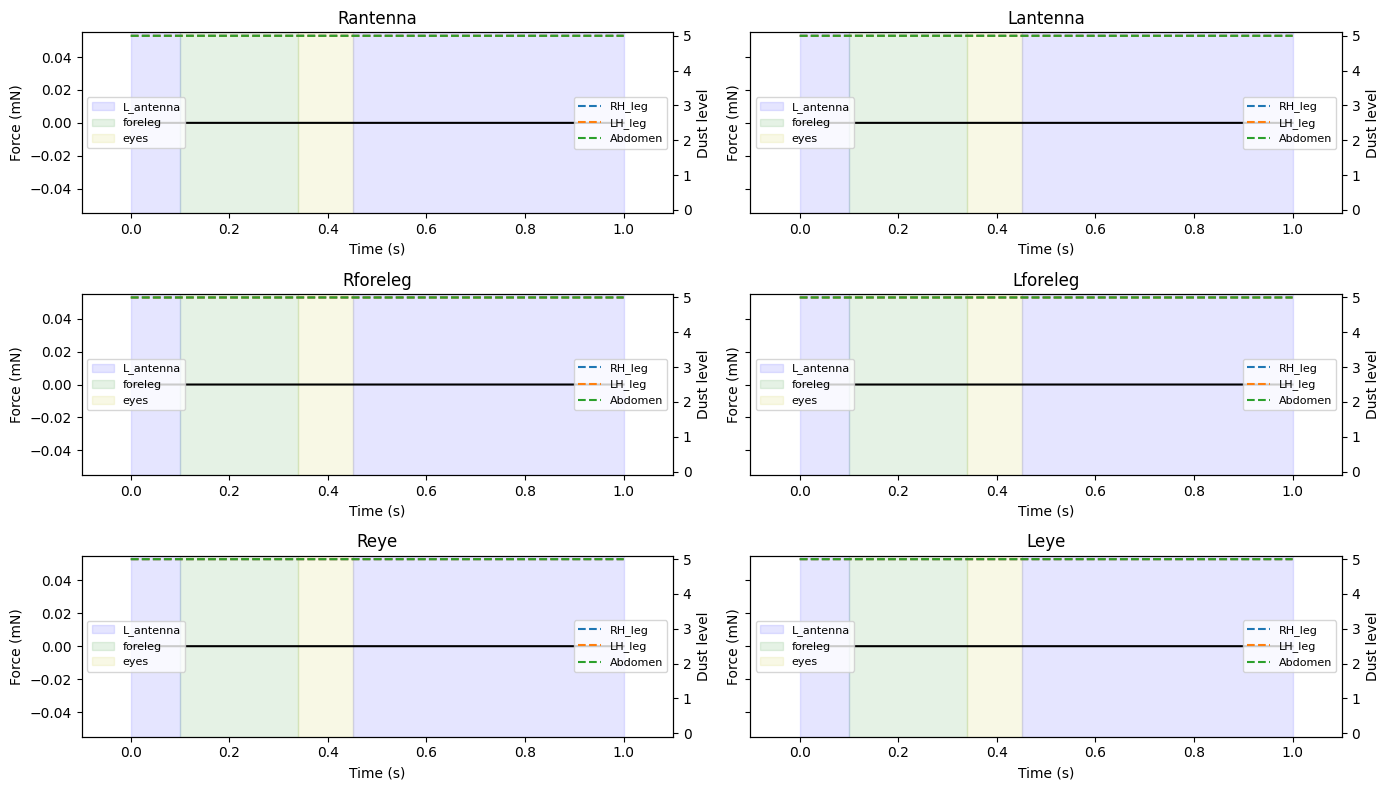

In [101]:
# plot touch sensor traces
touch_sensor_data = np.array([obs["touch_sensors"] for obs in obs_list])
dust_levels = np.array([obs["dust_level"] for obs in obs_list])
time = np.arange(touch_sensor_data.shape[0]) * sim_params.timestep

# plot touch sensor traces
touch_sensor_data = np.array([obs["touch_sensors"] for obs in obs_list])
time = np.arange(touch_sensor_data.shape[0]) * sim_params.timestep
fig, _ = plot_state_and_contacts(
    time,
    touch_sensor_data,
    nmf.touch_sensor_locations,
    transit_to,
    transit_times,
    dust_levels,
    nmf.dusted_areas,
)